# Introduction

This Notebook will demonstrate the process of training the model on a set of images, while intentionally injecting drop errors into the data. In our case, "drop errors" refer to randomly removing certain object classes (like 'sky' or 'car') from the images to see how the model performs without this data. 

We will be using the SYNTHIA [1] dataset in combination with the DeepLabV3+ model framework, made accessible through the `segmentation_models_pytorch` package. Download the SYNTHIA-SF dataset from: [synthia-dataset.net](https://synthia-dataset.net/)

The training data is divided into training and validation sets. One plug and play with different models or datasets as desired. It's important to note that our goal is to output predictions on this synthetic dataset and analyze how our model performs under these controlled error conditions, with results saved into .npy files for later evaluation. Semantic segmentation partitions an image into segments (sets of pixels). This aids in simplifying the representation of an image into something more meaningful and easier to analyze. 

### Import Statements

This training notebook uses the SYNTHIA dataset, introduces drop errors (comment and uncomment other errors for Shift and Swap) into the dataset. It then trains a DeepLabV3+ (or FPN) on the datasets. The results are then saved to `.npy` files in batches.

<a target="_blank" href="https://colab.research.google.com/github/cleanlab/examples/blob/master/semantic_segmentation/SYNTHIA_deeplab_dropped_labels_model_training.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Please install the dependencies specified in this [requirements.txt](https://github.com/cleanlab/examples/blob/master/segmentation/requirements.txt) file before running the notebook

In [ ]:
import os
import torch
import numpy as np
import segmentation_models_pytorch as smp
import albumentations as albu
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import cv2
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import os.path as osp
from scipy.interpolate import interp1d

### Select Device

In [13]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
torch.cuda.empty_cache()

### Visualize Helper

In [14]:
# Helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Set-up Shift Error Code

In [15]:
# We create this vector class for the function perturb_nat below, to quickly create shift pertubation errors
class Vector2():
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __add__(self, other):
        return Vector2(self.x + other.x, self.y + other.y)
    def __sub__(self, other):
        return Vector2(self.x - other.x, self.y - other.y)
    def __mul__(self, other):
        return Vector2(self.x * other, self.y * other)

    def magnitude(self):
        return (self.x**2 + self.y**2) ** 0.5

    def unitV(self):
        if self.magnitude() == 0:
            return Vector2(0,0)
        return Vector2(self.x / self.magnitude(), self.y / self.magnitude())

    def dotP(self, other):
        return (self.x * other.x) + (self.y * other.y)

    @staticmethod
    def randomVector():
        return Vector2(random.uniform(-1, 1), random.uniform(-1, 1))

    def __str__(self):
        return "x = " + str(self.x) + " y = " + str(self.y)


def smooth_function(center, variance):
    x = np.linspace(0, 2*np.pi, num = 6, endpoint = True)
    y = np.random.normal(center, variance**0.5, 5)
    y = np.append(y, y[0])
    return interp1d(x, y, kind='cubic')


In [16]:
# Input image and output a perturbed one
def perturb_nat(image, variance):
    center = 0
    contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    output = np.zeros(np.shape(image))
    if len(contours) == 0: # blank image
        return output

    for contour in contours:
        f = smooth_function(center, variance)
        size = len(contour)

        br = cv2.boundingRect(contour)
        cx = br[0] + br[2] / 2
        cy = br[1] + br[3] / 2
        center_point = Vector2(cx, cy)

        for count, point in enumerate(contour):
            x = (count / size) * 2 * np.pi
            distance_to_move = f(x)
            current_point = Vector2(point[0][0], point[0][1])
            direction = current_point - center_point
            direction = direction.unitV()
            offset = direction * distance_to_move
            contour[count][0] = [current_point.x - offset.x, current_point.y - offset.y]

        cv2.fillPoly(output, pts=[contour], color=1)
    return output

### Dataset Class

This section defines the Dataset class, where we process and augment the SYNTHIA images and their corresponding labels, and apply intentional drop errors to simulate potential issues in real-world data collection.

In [17]:
class Dataset(BaseDataset):
    """SYNTHIA Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['unlabeled','sky', 'building', 'road', 'sidewalk', 'fence', 'vegetation','pole','car', \
               'traffic sign','person','bicycle','motorcycle','traffic light', 'terrain', \
               'rider',  'truck', 'bus', 'train','wall']

    def __init__(
            self, 
            root, 
            list_path,
            split=None, 
            mode=None,
            classes=None,
            target_type='semantic',
            augmentation=None, 
            preprocessing=None,
    ):
                
        
        self.root = root
        self.list_path = list_path+"/sf_"+split+".txt"
        self.img_ids = [i_id.strip() for i_id in open(self.list_path)]
        self.files = []
        self.split = split
        for name in self.img_ids:
            #
            img_file = osp.join(self.root, "RGBRight/%s" % name)
            label_file = osp.join(self.root, "GTright/%s" % name)
            self.files.append({
                "img": img_file,
                "label": label_file,
                "name": name
            })
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
        # Mapping of ignore categories and valid ones (numbered from 1-19)
        self.mapping_20 = {0: 0, 1: 3, 2: 4, 3: 2, 4: 19, 5: 5, 6:7, 7: 13, 8: 9, \
                           9: 6, 10: 14, 11: 1, 12: 10, 13: 15, 14: 8, 15: 16, 16: 17, \
                           17: 18, 18: 12, 19: 11, 20: 3, 21: 0, 22: 0}
        np.random.seed(seed=3)

        self.drop_sky={i for i in range(len(self.files)) if np.random.random(1) >= 0.90}
        self.drop_car={i for i in range(len(self.files)) if np.random.random(1) >= 0.90}
#         self.shift_sky={i for i in range(len(self.files)) if np.random.random(1) >= 0.95}
#         self.swap_sky={i for i in range(len(self.files)) if np.random.random(1) >= 0.95}
        
    def __getitem__(self, i):
        def encode_labels(mask):
            label_mask = np.zeros_like(mask)
            for k in self.mapping_20:
                label_mask[mask == k] = self.mapping_20[k]
            return label_mask
        
        # read data
        datafiles = self.files[i]
        image = cv2.imread(datafiles["img"])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(datafiles["label"], -1)
        mask = mask[:,:,2]
        
        image, mask  = np.asarray(image), encode_labels(np.asarray(mask))
        
        
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        true_index_sky = self.CLASSES.index("sky")
        true_index_car = self.CLASSES.index("car")
        
        #Drop sky
        if i in self.drop_sky:
#             print("Dropped Sky")
            mask[:,:,0] += mask[:,:,true_index_sky]
            mask[:,:,true_index_sky] = np.zeros_like(mask[:,:,0])
        #Drop car
        if i in self.drop_car:
#             print("Dropped Car")
            mask[:,:,0] += mask[:,:,true_index_car]
            mask[:,:,true_index_car] = np.zeros_like(mask[:,:,0])
            
        
#         #Shift sky
#         if i in self.shift_sky:
#             #if perturb shrinks, map excess to unlabel 
#             perturbed = perturb_nat(mask[:,:,true_index_sky].astype("uint8"),1200)
#             diff = mask[:,:,true_index_sky] - perturbed
#             diff = (diff>0.).astype(int)
#             mask[:,:,0] += diff
            
#             #if perturb expands, make room on all other classes 
#             for idx in range(20):
#                 mask[:,:,idx][perturbed==1] = 0
            
#             #set as perturb
#             mask[:,:,true_index_sky] = perturbed
        
            
#         #Swap sky
#         if i in self.swap_sky:
#             temp1 = mask[:,:,true_index_sky].copy()
#             mask[:,:,true_index_sky] = mask[:,:,true_index_car]
#             mask[:,:,true_index_car] = temp1
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask'] 
        return image, mask
        
    def __len__(self):
        return len(self.files)

In [18]:
CLASSES = ['unlabeled','sky', 'building', 'road', 'sidewalk', 'fence', 'vegetation','pole','car', \
               'traffic sign','person','bicycle','motorcycle','traffic light', 'terrain', \
               'rider',  'truck', 'bus', 'train','wall']

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [20]:
image_width = 1920
image_height = 640

In [21]:
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=image_height, min_width=image_width, always_apply=True, border_mode=0),
        albu.RandomCrop(height=image_height, width=image_height, always_apply=True),
        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(min_width=1920, min_height=1088)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [22]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## Create model and train

Train the model, currently with the `image_net` backbone. Uncomment to train with the FPN model

The model weights can be automatically downloaded by entering the Encoder name and Weights as available on the [documentation](https://github.com/qubvel/segmentation_models.pytorch)

In [23]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['unlabeled','sky', 'building', 'road', 'sidewalk', 'fence', 'vegetation','pole','car', \
               'traffic sign','person','bicycle','motorcycle','traffic light', 'terrain', \
               'rider',  'truck', 'bus', 'train','wall']
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

#Uncomment to switch to different model
# model = smp.FPN(
#     encoder_name=ENCODER, 
#     encoder_weights=ENCODER_WEIGHTS, 
#     classes=len(CLASSES), 
#     activation=ACTIVATION,
# )

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
train_dataset = Dataset(
    "/datasets/username/synthia/SYNTHIA-SF/SEQ1",
    "/datasets/username/scripts_synthia/",
    split='train', 
    mode='fine', 
    classes=CLASSES, 
    target_type='semantic',
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = Dataset(
    "/datasets/username/synthia/SYNTHIA-SF/SEQ1",
    "/datasets/username/scripts_synthia/",
    split='test', 
    mode='fine', 
    classes=CLASSES, 
    target_type='semantic',
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=20, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=20,pin_memory=True)

In [25]:
import segmentation_models_pytorch.utils.metrics
loss = segmentation_models_pytorch.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [26]:
# create epoch runners 
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [29]:
# train model for 30 epochs
max_score = 0
losses=[]
scores=[]
for i in range(0, 30):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './synthia_sf_30_deeplab_with_test_deeplab_drop.pth')
        print('Model saved!')
        
    if i == 18:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')
        
    losses.append(train_logs['dice_loss'])
    scores.append(train_logs['iou_score'])

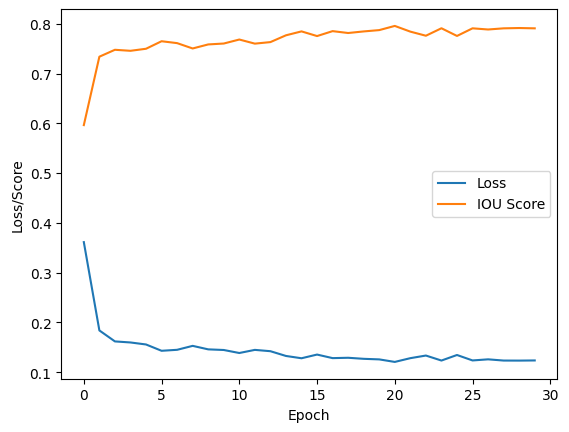

In [27]:
plt.plot(losses, label="Loss")
plt.plot(scores, label="IOU Score")
plt.xlabel("Epoch")
plt.ylabel("Loss/Score")
plt.legend()
plt.show()

## Test best saved model

In [30]:
best_model = torch.load('../../synthia_sf_30_deeplab_with_test_deeplab_drop.pth') # load best saved checkpoint

In [ ]:
test_dataset = Dataset(
    "/datasets/username/synthia/SYNTHIA-SF/SEQ1",
    "/datasets/username/scripts_synthia/",
    split='test', 
    mode='fine', 
    classes=CLASSES, 
    target_type='semantic',
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

test_dataloader = DataLoader(test_dataset)

In [32]:
len(test_dataset)

1112

### Run On Test Set

In [31]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 1112/1112 [22:29<00:00,  1.21s/it, dice_loss - 0.0583, iou_score - 0.8967] 


## Visualize predictions

Visualize Predictions: This section is dedicated to visualizing the semantic segmentation predictions of our model, enabling us to better understand its performance and accuracy.

In [33]:
test_dataset_vis = Dataset(
     "/datasets/username/synthia/SYNTHIA-SF/SEQ1",
    "/datasets/username/scripts_synthia/",
    split='test', 
    mode='fine', 
    classes=CLASSES, 
    target_type='semantic',
)

unlabeled
(20, 1088, 1920)


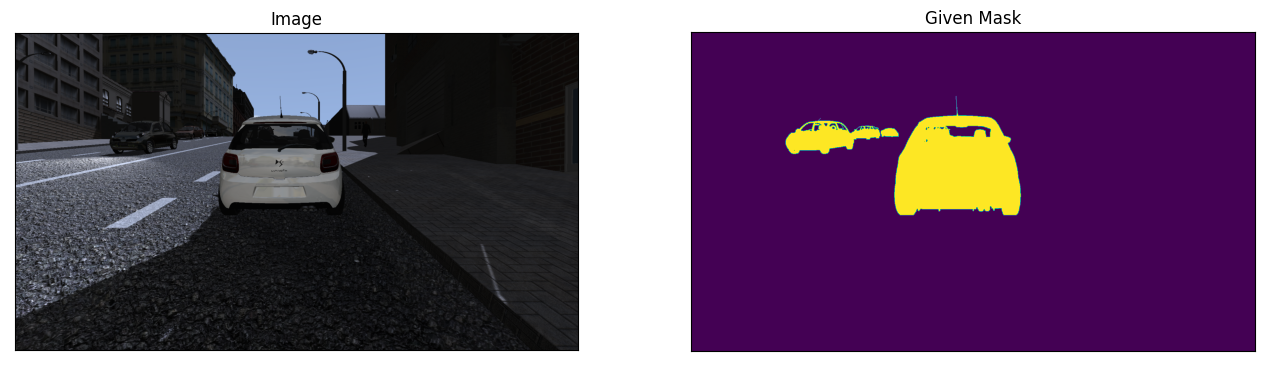

sky
(20, 1088, 1920)


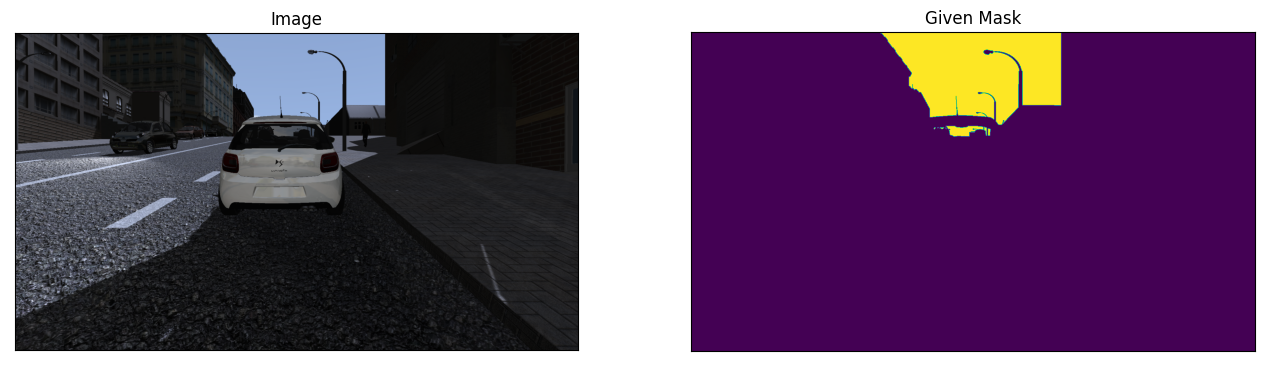

building
(20, 1088, 1920)


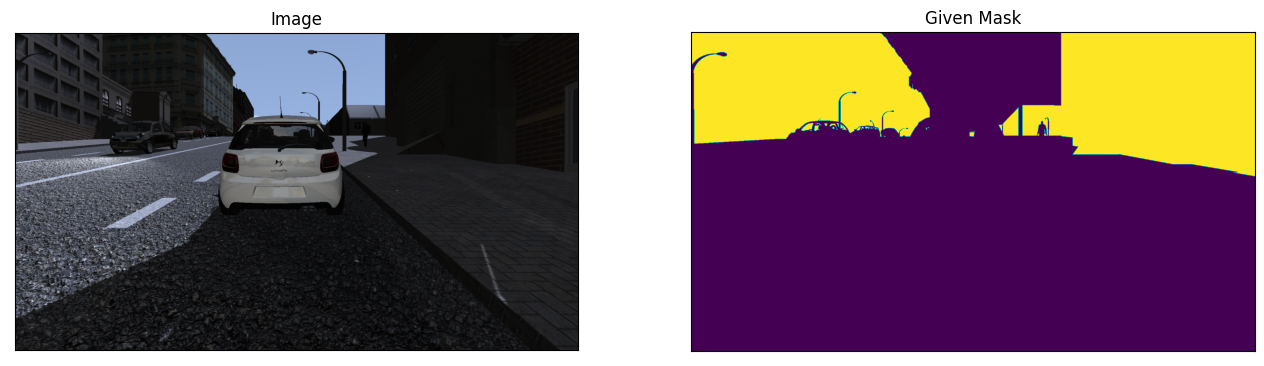

road
(20, 1088, 1920)


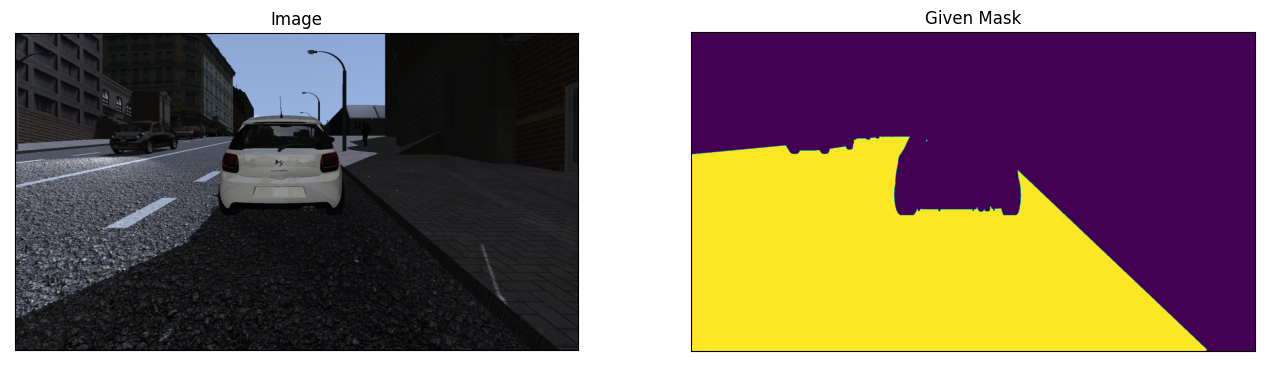

sidewalk
(20, 1088, 1920)


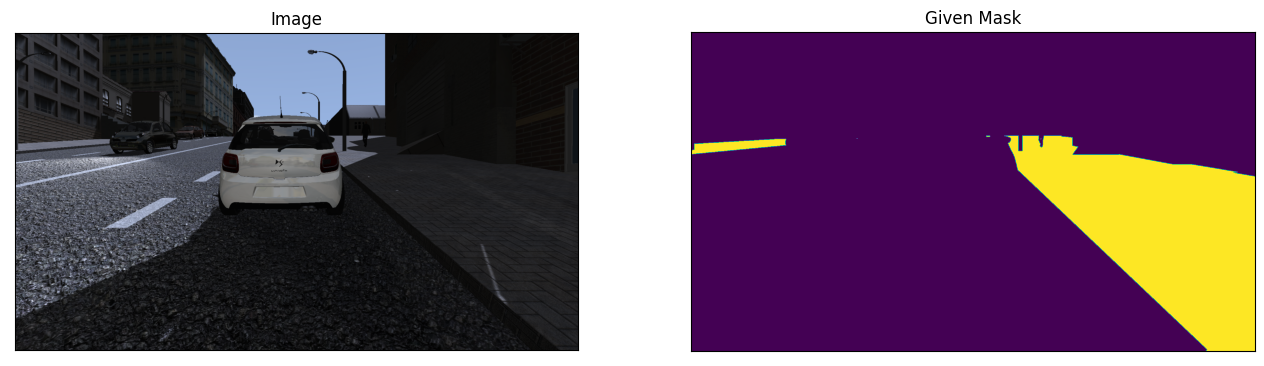

fence
(20, 1088, 1920)


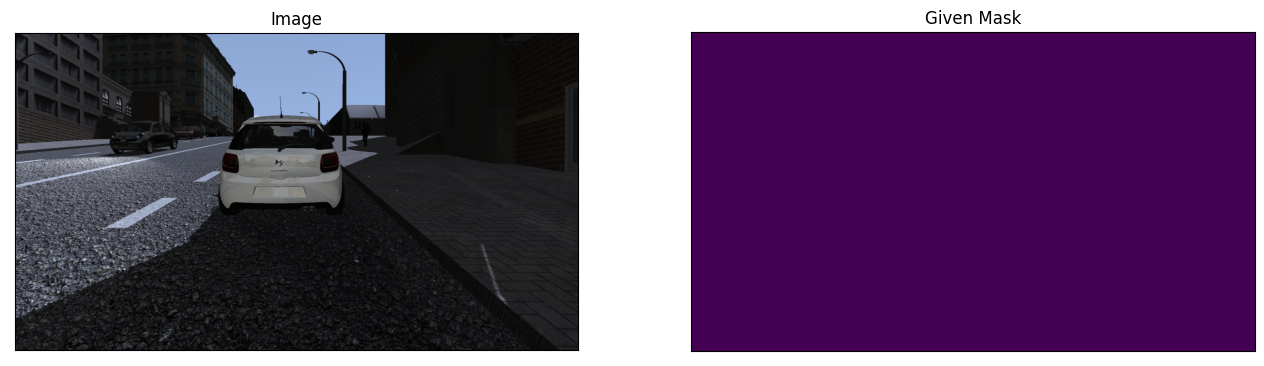

vegetation
(20, 1088, 1920)


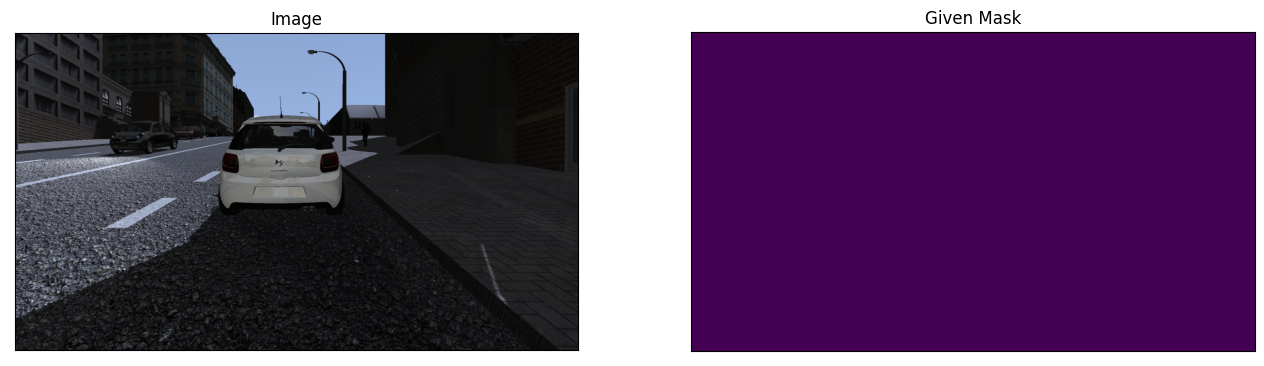

pole
(20, 1088, 1920)


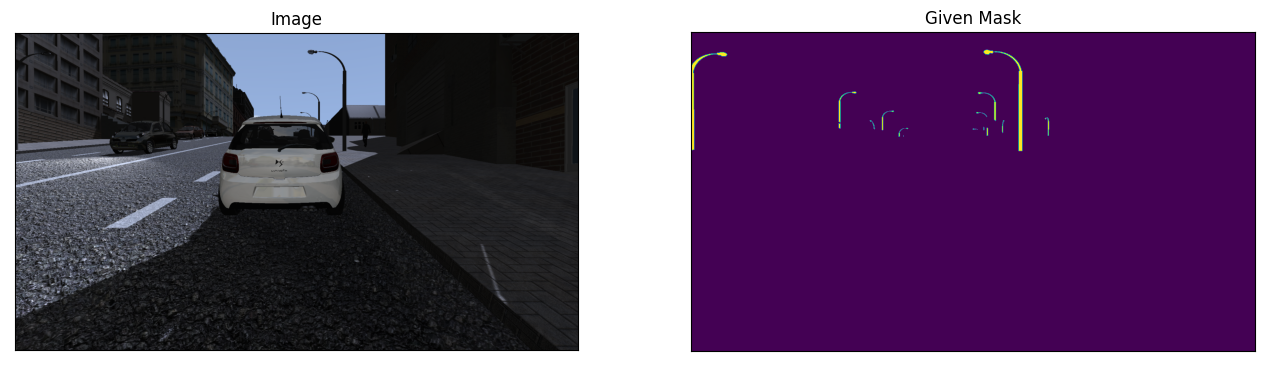

car
(20, 1088, 1920)


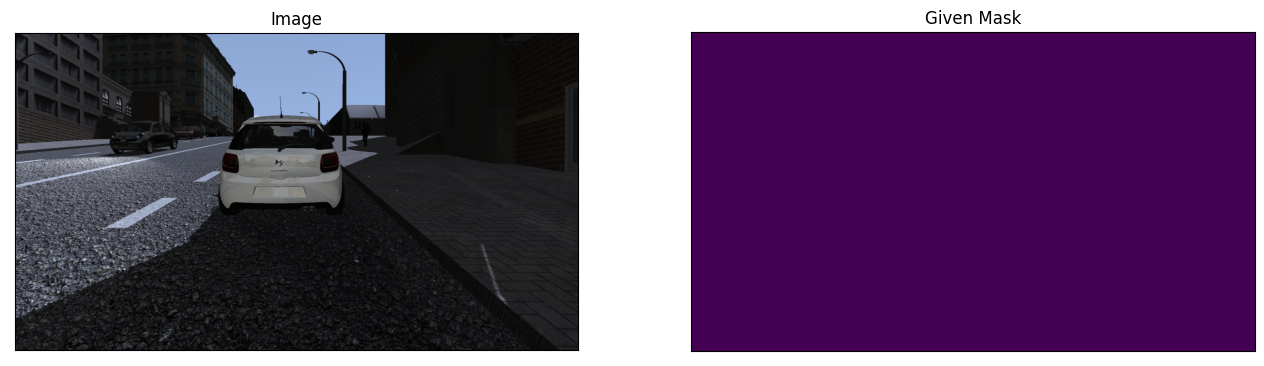

traffic sign
(20, 1088, 1920)


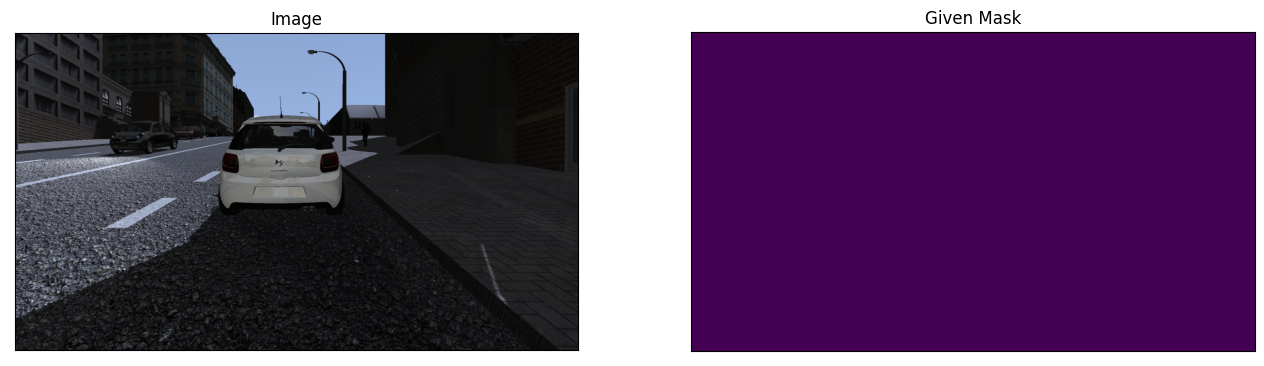

person
(20, 1088, 1920)


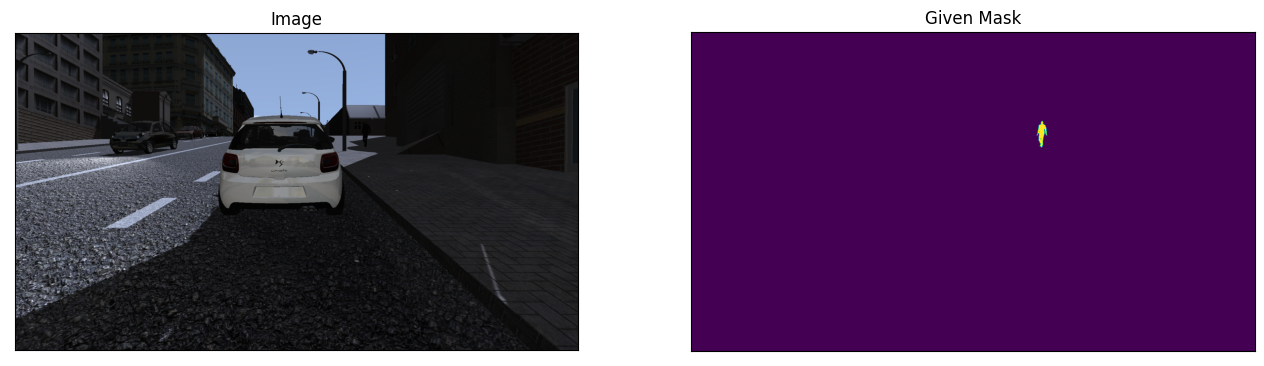

bicycle
(20, 1088, 1920)


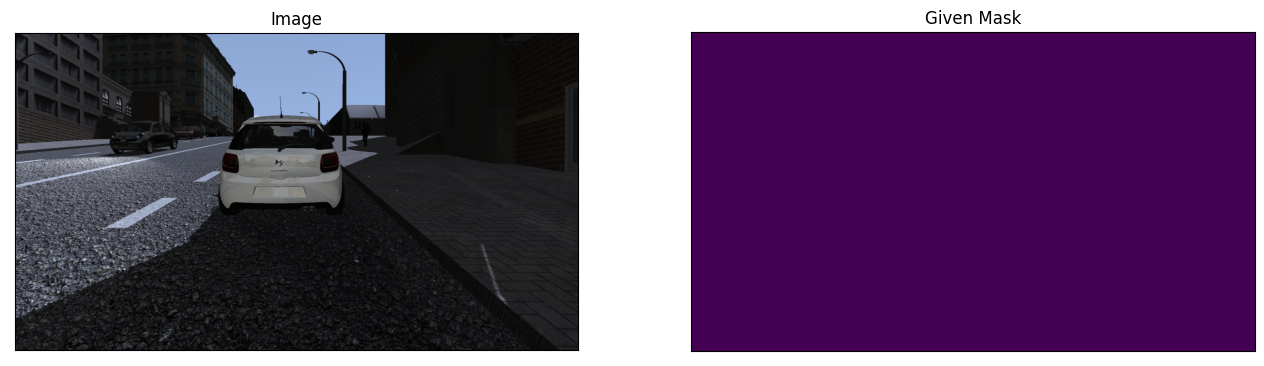

motorcycle
(20, 1088, 1920)


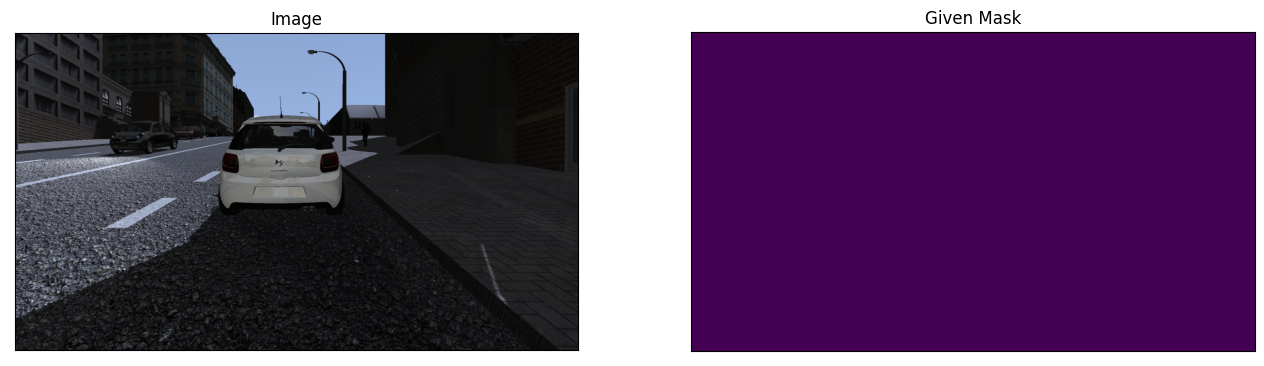

traffic light
(20, 1088, 1920)


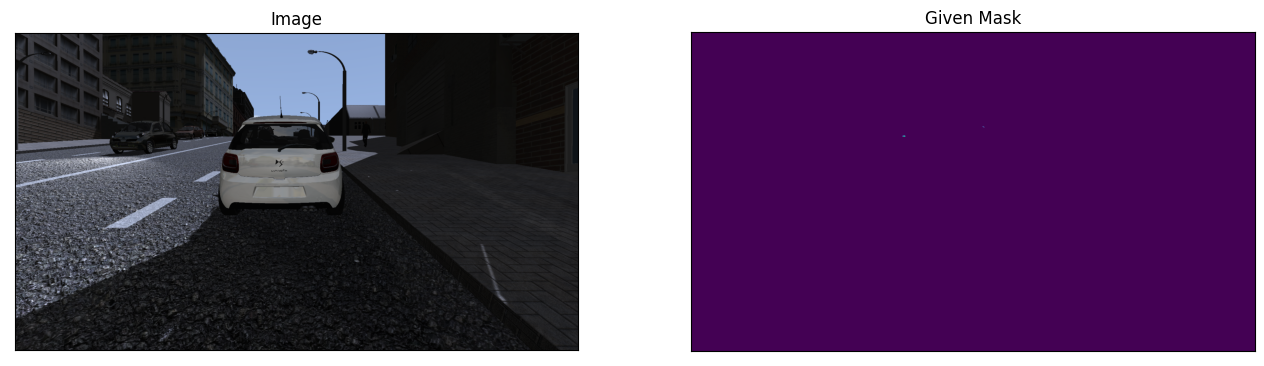

terrain
(20, 1088, 1920)


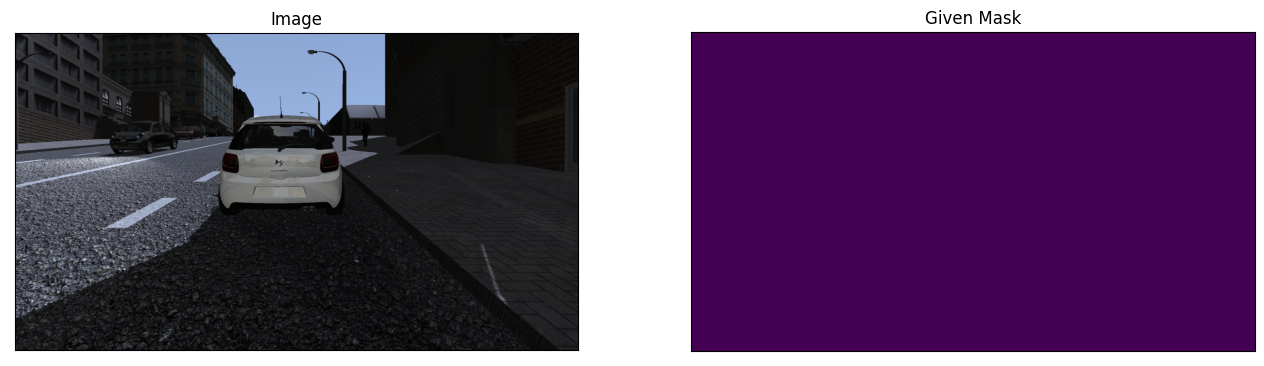

rider
(20, 1088, 1920)


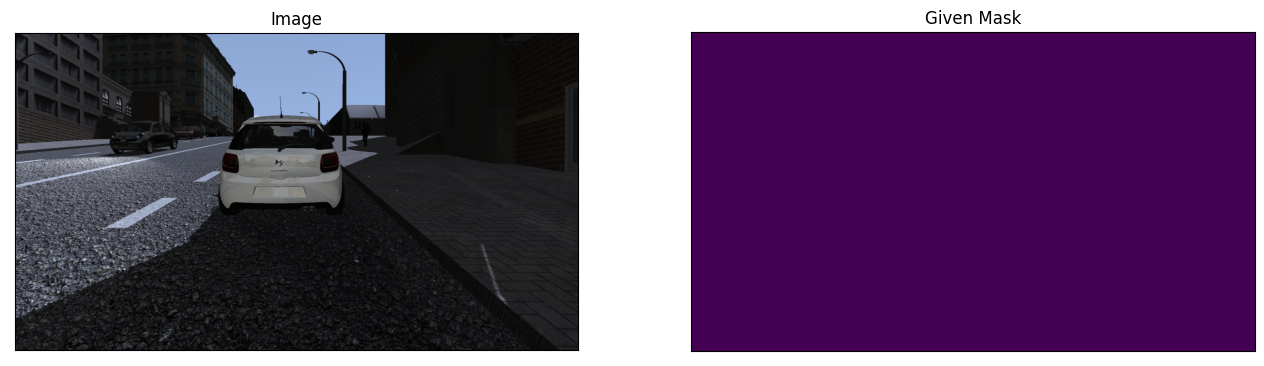

truck
(20, 1088, 1920)


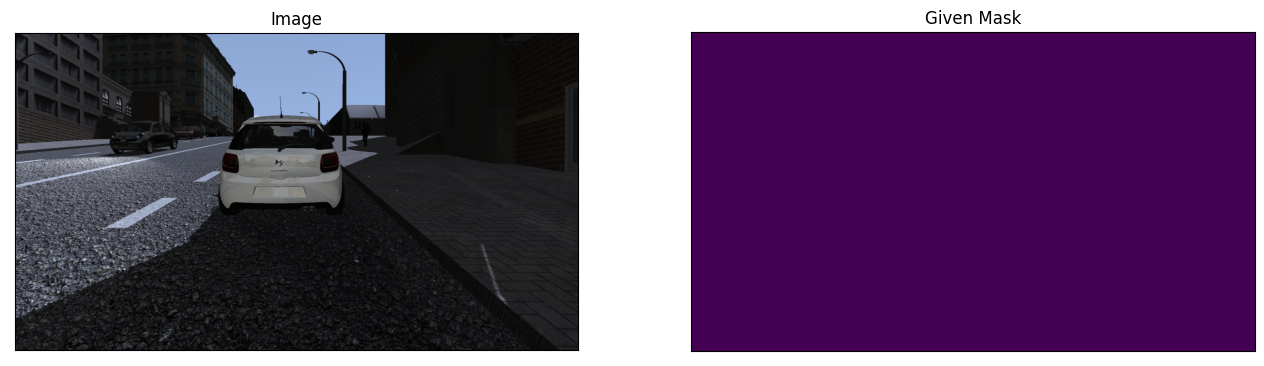

bus
(20, 1088, 1920)


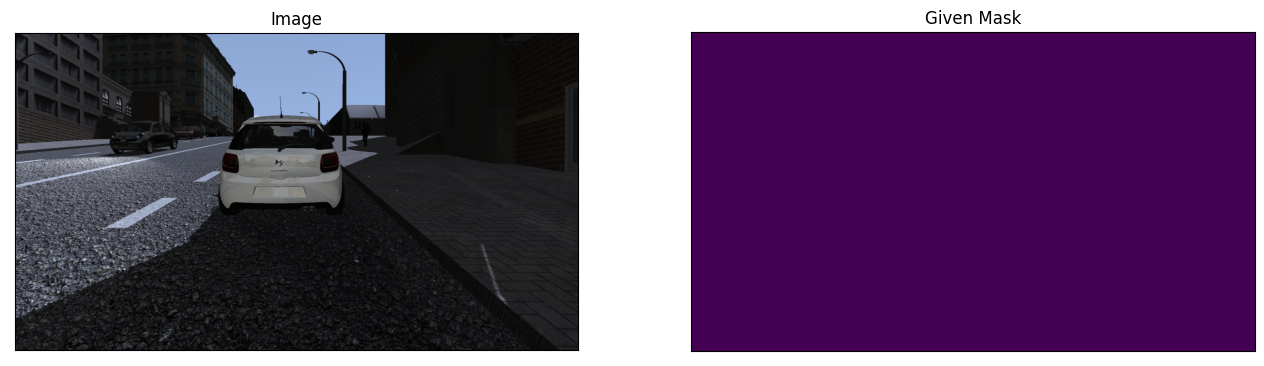

train
(20, 1088, 1920)


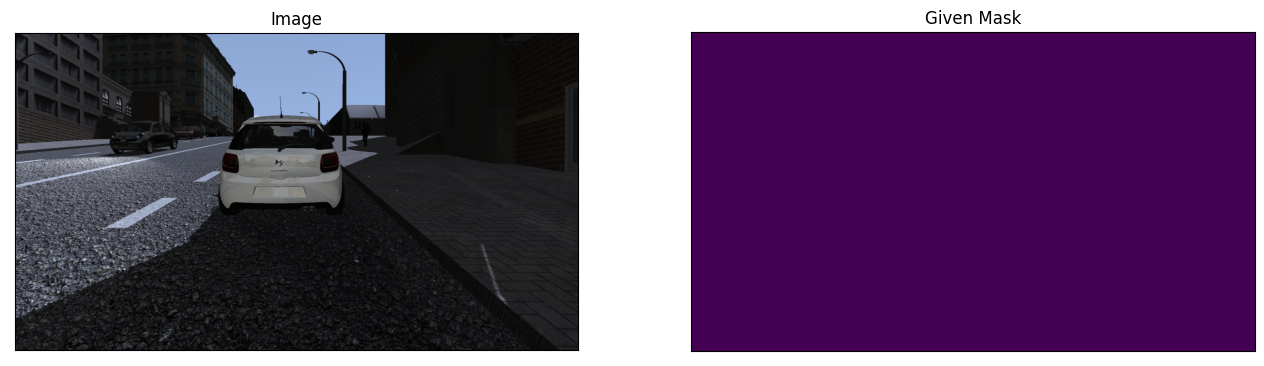

wall
(20, 1088, 1920)


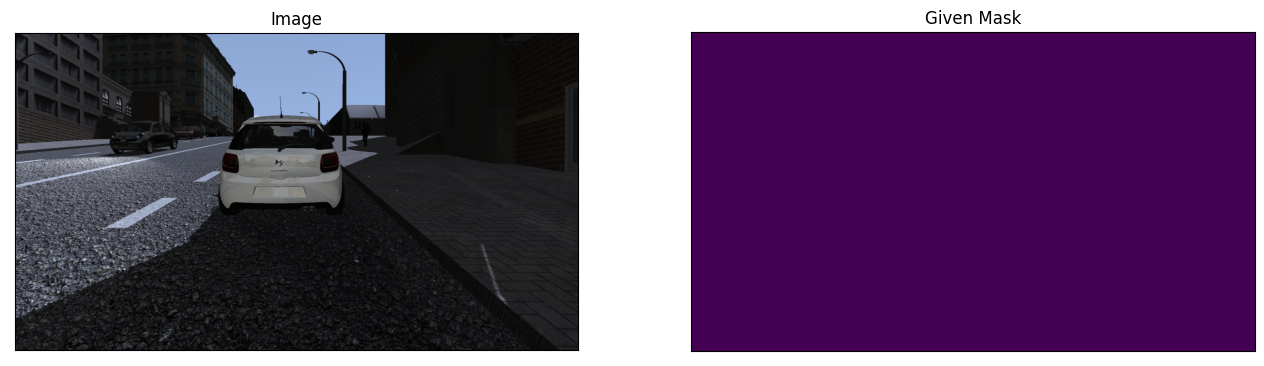

In [34]:
for index in range(len(CLASSES)):
    print(CLASSES[index])
    n=4
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)

    pr_mask = (pr_mask.squeeze().cpu().numpy())   
    print(gt_mask.shape)
    visualize(
        image=image_vis, 
        given_mask=gt_mask[index,:,:], 
#         predicted_mask=pr_mask[index,:,:]
    )

In [35]:
test_dataset = Dataset(
    "/datasets/username/synthia/SYNTHIA-SF/SEQ1",
    "/datasets/username/scripts_synthia/",
    split='test', 
    mode='fine', 
    classes=CLASSES, 
    target_type='semantic',
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

### Check Errors and Indicies

In [36]:
import itertools
s = set(itertools.chain(train_dataset.drop_sky, train_dataset.drop_car)) 
errors = np.array([1 if x in s else 0 for x in range(len(test_dataset))])
len(s), len(test_dataset)

(212, 1112)

In [37]:
import itertools
s = set(itertools.chain(test_dataset.drop_sky, test_dataset.drop_car)) 
errors = np.array([1 if x in s else 0 for x in range(len(test_dataset))])

In [40]:
model_name = "deeplab"
err_type = "drop"

### Save .npy in batches

Save .npy in Batches: This section covers the process of saving our model's output in batches as .npy files, which facilitates efficient storage and subsequent analysis of the generated results.

In [41]:
# Preallocate memory
to_save = 1112
cls, h, w = 20, 1088, 1920 #Change this to shrink
gts=np.empty((139, h, w), dtype="int8")
prs_unrounded=np.empty((139, cls, h, w),dtype="float16")

count = 0
name = 0

# Save in batches
for im in tqdm(range(to_save)):
    n = im   
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask_notrounded = (pr_mask.squeeze().cpu().numpy())
    gts[count] = np.argmax(gt_mask,axis=0).astype("int8")
    prs_unrounded[count] = pr_mask_notrounded.astype("float16")
    count+=1
    if count%139==0:
        name+=1
        if name>0:
            np.save(f"synthia_given_masks_{to_save}_{name}_{model_name}_{err_type}", gts)
            np.save(f"synthia_unrounded_predicted_masks_{to_save}_{name}_{model_name}_{err_type}", prs_unrounded)
            gts=np.empty((139, h, w), dtype="int8")
            prs_unrounded=np.empty((139, cls, h, w), dtype="float16")
            count=0

100%|██████████| 1112/1112 [1:11:30<00:00,  3.86s/it]


In [34]:
np.save(f"errors_{to_save}_drop", errors)

### References

[1] G. Ros, L. Sellart, "The SYNTHIA Dataset: A Large Collection of Synthetic Images for Semantic Segmentation of Urban Scenes," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, 2016, pp. 3234-3243, doi: 10.1109/CVPR.2016.352.